# IBIS to SPICE Model conversion
This notebook documents the process of converting an IBIS model to a SPICE model. 
The model used as an example is the NXP semiconductor 2-input AND-Gate model hct1g08.ibs - https://assets.nexperia.com/documents/ibis-model/hct1g08.ibs

The Basic steps of the conversation are: 

* Read IBIS file and store the various variables into numpy arrays. 
* The IBIS file is read in using the ecdtools library: https://ecdtools.readthedocs.io/en/latest
* Adjust the Pullup and Pulldown waveforms to compensate for the clamp current
* Solve the K-Parameters for the Pullup and Pulldown devices for the rising and falling switching transients
* Package into a subcircuit model that can be used with SPICE tools

In [2]:
# Imports
import ecdtools
import numpy as np
import matplotlib.pyplot as plt

import sys
#sys.executable # Checks which python environment is being used

## Functions

In [2]:
# Pullup and Pulldown data may need to adjusted by subtracting the clamp data if the output has clamps. 
# This is because the clamp data is gathered when the output is at high impedance. However, the pullup and pulldown data is gathered with the clamps still there.
# Therefore, the equations should not take this into account twice. This function performs the adjustment

def adjust_device_data(device_table, clamp_table):
    # device_table = pullup or pulldown table
    # clamp_table = power_clamp or gnd_clamp table
    array_size = np.shape(device_table[:,0])[0] # Get size of the table data
    table_adj = np.zeros([array_size, 4])  # Create an empty table with the same size as the device table
    table_adj[:,0] = device_table[:,0]; # populate the first column of the new adjusted table with the voltage in the device table 
    
    # Subtract the clamp data via interpolation for the typical(1), minimum(2) and maximum(3)
    # Adjusted_Array = Device_Table_Current - interpolation(x, fx, fy). 
    # The interpolation finds the y value for the function y = f(x), described by arrays fx and fy at the point x.
    table_adj[:,1] = device_table[:,1] - np.interp(table_adj[:,0], clamp_table[:,0], clamp_table[:,1])
    table_adj[:,2] = device_table[:,2] - np.interp(table_adj[:,0], clamp_table[:,0], clamp_table[:,2])
    table_adj[:,3] = device_table[:,3] - np.interp(table_adj[:,0], clamp_table[:,0], clamp_table[:,3])
    
    return table_adj

In [3]:
# Plot function with two plots organised horizontally
def plot(table1, table2, xlabel, ylabel, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    line1 = ax1.plot(table1[:,0], table1[:,1], label='Typ')
    line2 = ax1.plot(table1[:,0], table1[:,2], label='Min')
    line3 = ax1.plot(table1[:,0], table1[:,3], label='Max')
    ax1.legend()
    ax1.grid(color='0.9')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title(title1)
    
    line1 = ax2.plot(table2[:,0], table2[:,1], label='Typ')
    line2 = ax2.plot(table2[:,0], table2[:,2], label='Min')
    line3 = ax2.plot(table2[:,0], table2[:,3], label='Max')
    ax2.legend()
    ax2.grid(color='0.9')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)
    ax2.set_title(title2)
    
    fig.tight_layout(w_pad=5, h_pad=2)

    plt.show()

In [4]:
# Plot function with two plots organised horizontally
def plot_k_params(table1, table2, xlabel, ylabel, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    line1 = ax1.plot(table1[:,0], table1[:,1], label='Ku')
    line2 = ax1.plot(table1[:,0], table1[:,2], label='Kd')
    ax1.legend()
    ax1.grid(color='0.9')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title(title1)
    
    line1 = ax2.plot(table2[:,0], table2[:,1], label='Ku')
    line2 = ax2.plot(table2[:,0], table2[:,2], label='Kd')
    ax2.legend()
    ax2.grid(color='0.9')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)
    ax2.set_title(title2)
    
    fig.tight_layout(w_pad=5, h_pad=2)

    plt.show()

## User Inputs

In [3]:
file_path = 'IBIS_models/hct1g08.ibs'
model_name = 'HCT1G08_OUTN_50'
component_name = '74HCT1G08_GW'

## Read IBIS file into numpy arrays

### Define the Model and Component and store in memory

In [6]:
ibs = ecdtools.ibis.load_file(file_path, transform=True) # Transform=True converts numerical numbers from strings to decimal
print(ibs.model_names) # List of model names
print(ibs.component_names) # List of components

# Store the model and component in memory
model = ibs.get_model_by_name(model_name)
component = ibs.get_component_by_name(component_name) 

print(model.model_type)

['HCT1G08_IN_50', 'HCT1G08_OUTN_50']
['74HCT1G08_GV', '74HCT1G08_GW']
Output


### Get the package parasitics, die capacitance and voltage range

In [7]:
# Get the pacakge parasitics R_pkg, L_pkg, C_pkg
# The package parasitics are related to component. This model has two components
r_pkg = component.package.r_pkg
l_pkg = component.package.l_pkg
c_pkg = component.package.c_pkg

print(f'R_pkg = Typ: {r_pkg.typical}, Min: {r_pkg.minimum}, Max: {r_pkg.maximum}')
print(f'L_pkg = Typ: {l_pkg.typical}, Min: {l_pkg.minimum}, Max: {l_pkg.maximum}')
print(f'C_pkg = Typ: {c_pkg.typical}, Min: {c_pkg.minimum}, Max: {c_pkg.maximum}')

# Get the die capacitance of the output model
c_comp = model.c_comp
print(f'C_comp = Typ: {c_comp.typical}, Min: {c_comp.minimum}, Max: {c_comp.maximum}')

# Get the Voltage Range
voltage_range = model.voltage_range
print(f'Voltage Range = Typ: {voltage_range.typical}, Min: {voltage_range.minimum}, Max: {voltage_range.maximum}')

R_pkg = Typ: 0.08353, Min: 0.08341, Max: 0.08366
L_pkg = Typ: 1.484E-9, Min: 1.480E-9, Max: 1.486E-9
C_pkg = Typ: 2.355E-13, Min: 1.892E-13, Max: 3.527E-13
C_comp = Typ: 2.32E-12, Min: 1.86E-12, Max: 2.78E-12
Voltage Range = Typ: 5.0, Min: 4.5, Max: 5.5


### Get the pullup and pulldown data

In [8]:
# Get the Pullup and Pulldown Data - These are list of tuples.
# Each list contains a tuple of 4 values: Voltage, I_typ, I_min, I_max
print(f'Pullup Table First Value: {model.pullup[0]}')
print(f'Pulldown Table First Value: {model.pulldown[0]}')
pullup_table = np.asarray(model.pullup, dtype='float64')
pulldown_table = np.asarray(model.pulldown, dtype='float64')

Pullup Table First Value: (Decimal('-5.5000'), Decimal('2.3429'), Decimal('2.2746'), Decimal('2.5184'))
Pulldown Table First Value: (Decimal('-5.5000'), Decimal('-2.3731'), Decimal('-2.2672'), Decimal('-2.6156'))


### Get the Transient Waveform (Rising and Falling) Data

In [9]:
# Get the Transient Waveforms (Rising and Falling)
print(f'Number of Rising Waveforms = {len(model.rising_waveforms)}')
print(f'Number of Falling Waveforms = {len(model.falling_waveforms)}')

print()

rising_waveforms = []
# Rising Waveforms
for i, waveform in enumerate(model.rising_waveforms, start=0):
    v_fixture = waveform.v_fixture
    print(f'Rising Waveform {i}: R_fixture={waveform.r_fixture}, V_fixture = Typ:{v_fixture.typical} Min:{v_fixture.minimum} Max:{v_fixture.maximum}')
    rising_waveforms.append(np.asarray(model.rising_waveforms[i].table.samples, dtype='float64'))

falling_waveforms = []
# Falling Waveforms
for i, waveform in enumerate(model.falling_waveforms, start=0):
    v_fixture = waveform.v_fixture
    print(f'Falling Waveform {i}: R_fixture={waveform.r_fixture}, V_fixture = Typ:{v_fixture.typical} Min:{v_fixture.minimum} Max:{v_fixture.maximum}')
    falling_waveforms.append(np.asarray(model.falling_waveforms[i].table.samples, dtype='float64'))

Number of Rising Waveforms = 2
Number of Falling Waveforms = 2

Rising Waveform 0: R_fixture=50, V_fixture = Typ:0.000 Min:0.000 Max:0.000
Rising Waveform 1: R_fixture=50, V_fixture = Typ:5.0 Min:4.5 Max:5.5
Falling Waveform 0: R_fixture=50, V_fixture = Typ:0.000 Min:0.000 Max:0.000
Falling Waveform 1: R_fixture=50, V_fixture = Typ:5.0 Min:4.5 Max:5.5


### Get the Clamp Data and Adjust the Pullup and Pulldown Data

In [10]:
# For this output pin model, there are no clamps so the following statements return None
model.gnd_clamp
model.power_clamp

# Lets use the input clamps in place for the output clamps as an example
input_model = ibs.get_model_by_name('HCT1G08_IN_50')
gnd_clamp = np.asarray(input_model.gnd_clamp, dtype='float64')
pwr_clamp = np.asarray(input_model.power_clamp, dtype='float64')

# Adjusting pullup Data with the power clamp data 
pullup_table_adj = adjust_device_data(pullup_table, pwr_clamp)

# Adjusting pulldown data with the ground clamp data 
pulldown_table_adj = adjust_device_data(pulldown_table, gnd_clamp)

## Summary of Variables

*The data tables are always organised as time/voltage, typical, minimum, maximum.*

| Variable | Description | Usage |
| :--- | :--- | :--- |
| `r_pkg` | package resistance |  `r_pkg.typical  r_pkg.minimum  r_pkg.maximum` |
| `l_pkg` | package inductance |  `l_pkg.typical  l_pkg.minimum  l_pkg.maximum` |
| `l_pkg` | package capacitance |  `c_pkg.typical  c_pkg.minimum  c_pkg.maximum` |
| `c_comp` | die capacitance |  `c_comp.typical  c_comp.minimum  c_comp.maximum` |
| `voltage_range` | Voltage Range used in the model |  `voltage_range.typical  voltage_range.minimum  voltage_range.maximum` |
| `gnd_clamp` | numpy array of the ground clamp IV table |  voltage = `gnd_clamp[:,0]` I_typ = `gnd_clamp[:,1]`|
| `pwr_clamp` | numpy array of the power clamp IV table |  voltage = `power_clamp[:,0]` I_typ = `power_clamp[:,1]`|
| `pullup_table` | numpy array of pullup IV table |  voltage = `pullup_table[:,0]` I_typ = `pullup_table[:,1]`|
| `pulldown_table` | numpy array of pulldown IV table |  voltage = `pulldown_table[:,0]` I_typ = `pulldown_table[:,1]`|
| `pullup_table_adj`* | numpy array of adjusted pullup IV table (adjusted for clamp data) |  voltage = `pullup_table_adj[:,0]` I_typ = `pullup_table_adj[:,1]`|
| `pulldown_table_adj`* | numpy array of adjusted pulldown IV table (adjusted for clamp data) |  voltage = `pulldown_table_adj[:,0]` I_typ = `pulldown_table_adj[:,1]`|
| `rising_waveforms` | list of numpy arrays of the rising waveform data |  `rising_waveforms[0]`  `rising_waveforms[1]` |
| `falling_waveforms` | list of numpy arrays of the falling waveform data |  `falling_waveforms[0]`  `falling_waveforms[1]` |
| `rising_waveforms[n][:,x]` | numpy array of x-column of the n'th rising waveform data |  Time=`rising_waveforms[n][:,0]`  V_typ=`rising_waveforms[n][:,1]` |
| `falling_waveforms[n][:,x]` | numpy array of x-column of the n'th falling waveform data |  Time=`falling_waveforms[n][:,0]`  V_typ=`falling_waveforms[n][:,1]` |
| `model.rising_waveforms[n].r_fixture` | the fixture resistance for rising waveform n |  `model.rising_waveforms[n].r_fixture` |
| `model.falling_waveforms[n].r_fixture` | the fixture resistance for falling waveform n |  `model.falling_waveforms[n].r_fixture` |
| `model.rising_waveforms[n].v_fixture` | the fixture voltage for rising waveform n |  `model.rising_waveforms[n].v_fixture.typical`  `model.rising_waveforms[n].v_fixture.minimum`  `model.rising_waveforms[n].v_fixture.maximum` |
| `model.falling_waveforms[n].v_fixture` | the fixture voltage for falling waveform n |  `model.falling_waveforms[n].v_fixture.typical`  `model.falling_waveforms[n].v_fixture.minimum`  `model.falling_waveforms[n].v_fixture.maximum` |


## Plotting the Data

### Rising and Falling Waveforms

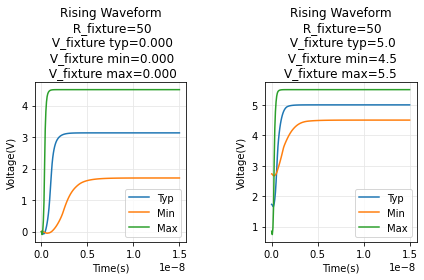

In [11]:
#Rising Waveforms
waveform = model.rising_waveforms
plot(rising_waveforms[0], rising_waveforms[1], xlabel='Time(s)', ylabel='Voltage(V)', 
     title1=f'Rising Waveform\n R_fixture={waveform[0].r_fixture}\n V_fixture typ={waveform[0].v_fixture.typical}\n V_fixture min={waveform[0].v_fixture.minimum}\n V_fixture max={waveform[0].v_fixture.maximum}', 
     title2=f'Rising Waveform\n R_fixture={waveform[0].r_fixture}\n V_fixture typ={waveform[1].v_fixture.typical}\n V_fixture min={waveform[1].v_fixture.minimum}\nV_fixture max={waveform[1].v_fixture.maximum}')

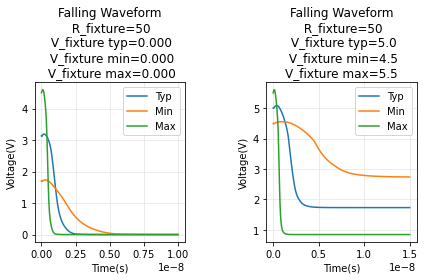

In [12]:
#Falling Waveforms
waveform = model.falling_waveforms
plot(falling_waveforms[0], falling_waveforms[1], xlabel='Time(s)', ylabel='Voltage(V)', 
     title1=f'Falling Waveform\n R_fixture={waveform[0].r_fixture}\n V_fixture typ={waveform[0].v_fixture.typical}\n V_fixture min={waveform[0].v_fixture.minimum}\n V_fixture max={waveform[0].v_fixture.maximum}', 
     title2=f'Falling Waveform\n R_fixture={waveform[0].r_fixture}\n V_fixture typ={waveform[1].v_fixture.typical}\n V_fixture min={waveform[1].v_fixture.minimum}\nV_fixture max={waveform[1].v_fixture.maximum}')

### Power and Ground Clamp IV Curves

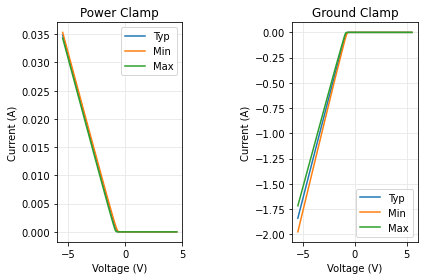

In [13]:
# Power Clamp and Ground Clamp IV curves
plot(pwr_clamp, gnd_clamp, xlabel='Voltage (V)', ylabel='Current (A)', title1='Power Clamp', title2='Ground Clamp')

### Pullup and Pulldown Device IV Curves

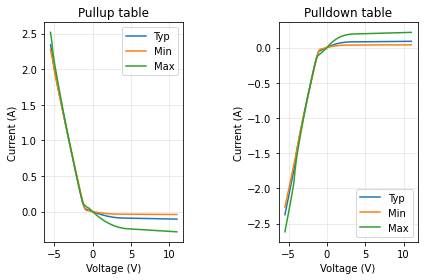

In [14]:
# Pull up and Pull down IV curves
plot(pullup_table, pulldown_table, xlabel='Voltage (V)', ylabel='Current (A)', title1='Pullup table', title2='Pulldown table')

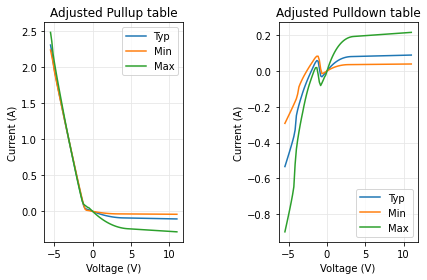

In [15]:
# Plotting adjusted Pullup and Pulldown data
plot(pullup_table_adj, pulldown_table_adj, xlabel='Voltage (V)', ylabel='Current (A)', title1='Adjusted Pullup table', title2='Adjusted Pulldown table')

## K-Parameters

### Explanation of K-Parameters

To obtain a SPICE model that be used in transient simulations, we need to define some time-varying paramters.
K-Parameters define the transient behaviour of the pullup and pulldown devices.

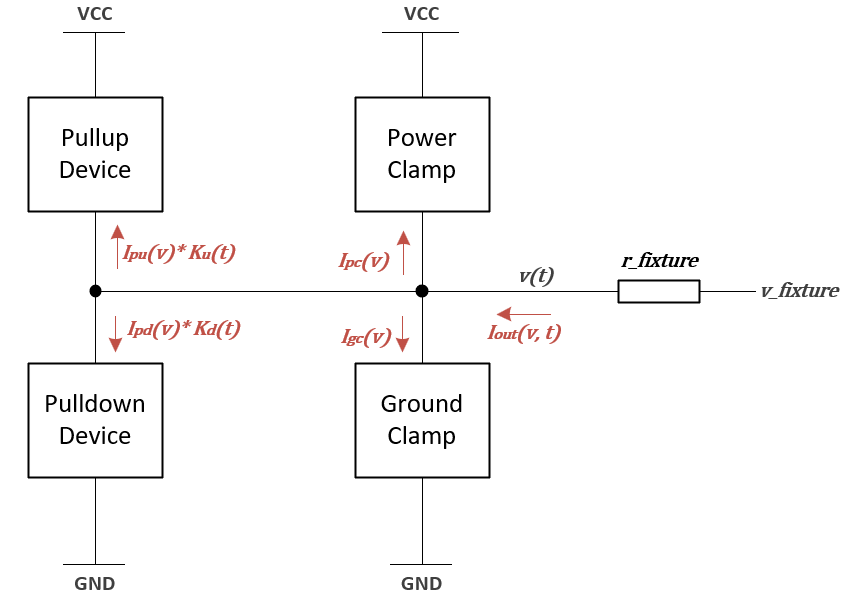

The KCL equation at the die node can be derived as:
$$ I_{out}(v, t) = I_{gc}(v) + I_{pc}(v) + I_{pu}(v,t) + I_{pd}(v,t) $$

* The varaiable $v$ is the voltage at the die node. The voltage at the die node over time is described by the Rising and Falling Waveform data
* $I_{gc}(v)$ can be found by the ground clamp I-V data
* $I_{pc}(v)$ can be found by the power clamp I-V data
* $I_{pu}(v, t) = I_{pu}(v(t)).K_u(t)$ - The pullup data IV characteristic is multiplied by a time-varying parameter $K_u(t)$
* $I_{pd}(v, t) = I_{pd}(v(t)).K_d(t)$ - The pulldown data IV characteristic is multiplied by a time-varying parameter $K_d(t)$
* $I_{out}(v,t) = \frac {V_{fixture} - v(t)}{R_{fixture}}$. Where, $v(t)$ is the rising or falling waveform data

The K-parameters $K_u(t)$ and $K_d(t)$ are values between 0 and 1 that define the switching characteristic of the pullup and pulldown device respectively. 

* In a rising edge, the $K_u(t)$ will vary from 0 to 1 and the $K_d(t)$ will vary from 1 to 0. 
* In a falling edge, the $K_u(t)$ will vary from 1 to 0 and the $K_d(t)$ will vary from 0 to 1. 

The K-paramters ($K_u(t)$ and $K_d(t)$) are unknowns that need to be solved. Since the IBIS model has two waveforms for any edge, there are two equations and two unknowns. Therefore, the unknwons can be solved.

The equation can be written in a matrix form: 

$$
\begin{bmatrix} I_{out}(1) \\ I_{out}(2) \\ \vdots \\ I_{out}(n) \end{bmatrix} = 
\begin{bmatrix} I_{pu}(v(1)).K_u(1) \\ I_{pu}(v(2)).K_u(2) \\ \vdots \\ I_{pu}(v(n)).K_u(n) \end{bmatrix} +
\begin{bmatrix} I_{pd}(v(1)).K_d(1) \\ I_{pd}(v(2)).K_d(2) \\ \vdots \\ I_{pd}(v(n)).K_d(n) \end{bmatrix} +
\begin{bmatrix} I_{pc}(v(1)) \\ I_{pc}(v(2)) \\ \vdots \\ I_{pc}(v(n)) \end{bmatrix} + 
\begin{bmatrix} I_{gc}(v(1)) \\ I_{gc}(v(2)) \\ \vdots \\ I_{gc}(v(n)) \end{bmatrix}
$$


Simplifying:
$$
I_{out1} - I_{gc1} - I_{pc1} =  (K_u.I_{pu1}) + (K_d.I_{pd1})
$$
$$
I_{out2} - I_{gc2} - I_{pc2} =  (K_u.I_{pu2}) + (K_d.I_{pd2})
$$

The suffix 1 and 2 in the equations indicate the two waveform conditions (e.g. 5V and 0V) given in the ibis model. 

$$
I_1 = (K_u.I_{pu1}) + (K_d.I_{pd1})
$$
$$
I_2 = (K_u.I_{pu2}) + (K_d.I_{pd2})
$$

$$
\begin{bmatrix} I_1 \\ I_2 \end{bmatrix} = 
\begin{bmatrix} I_{pu1} & I_{pd1} \\ I_{pu2} & I_{pd2} \end{bmatrix}.
\begin{bmatrix} K_u \\ K_d \end{bmatrix}
$$


$I_1, I_2, I_{pu1}, I_{pd1}, I_{pu2}$ and $I_{pd2}$ are all known quantities, therefore, the $K_u(t)$ and $K_d(t)$ parameters can be solved for both the rising and falling edges. For differentiation, these are named:
* Rising Edge: $K_{ur}(t)$ and $K_{dr}(t)$
* Falling Edge: $K_{uf}(t)$ and $K_{df}(t)$



### Solving K-Paramters

#### Function Definition

In [16]:
#Function to solve the K-parameters
def solve_k_params(w1, w1_vfix, w1_rfix, w2, w2_vfix, w2_rfix, corner='Typical'):
    
    # w1 is the numpy array of the rising/falling waveform with corresponding v_fixture (w1_vfix) and r_fixutre (w1_rfix)
    # w2 is the numpy array of the second rising/falling waveform with its corresponding v_fixture (w1_vfix) and r_fixutre (w1_rfix)
    # the corner is a string value of either 'Typical', 'Minimum' or 'Maximum'. This defines, which corner to use for the given w1 and w2 data
    
    # Define some constants to help with readability
    TIME = 0
    VOLTAGE = 0
    
    if corner == 'Minimum':
        CORNER_INDEX = 2
        vcc = float(voltage_range.minimum)
        c_comp_tmp = float(c_comp.minimum)
    
    elif corner == 'Maximum':
        CORNER_INDEX = 3
        vcc = float(voltage_range.maximum)
        c_comp_tmp = float(c_comp.maximum)
    
    else: # Default case is the Typical Corner
        CORNER_INDEX = 1
        vcc = float(voltage_range.typical)
        c_comp_tmp = float(c_comp.typical)
    
    
    # Resample and combine the time waveforms
    time = np.concatenate((w1[:,TIME], w2[:,TIME]))
    time = np.sort(time)
    time = np.unique(time)
    array_size = np.shape(time)[0]
    
    # Resampling the pullup, pulldown, power and ground clamp waveforms to the new time series 
    # Waveform 1
    vt1 = np.interp(time, w1[:,TIME], w1[:,CORNER_INDEX])
    i_pu1 = np.interp(vt1, np.flip(vcc - pullup_table[:,VOLTAGE]), np.flip(pullup_table[:,CORNER_INDEX]))
    i_pd1 = np.interp(vt1, pulldown_table[:,VOLTAGE], pulldown_table[:,CORNER_INDEX])
    i_pc1 = np.interp(vt1, np.flip(vcc - pwr_clamp[:,VOLTAGE]),  np.flip(pwr_clamp[:,CORNER_INDEX]))
    i_gc1 = np.interp(vt1, gnd_clamp[:,VOLTAGE], gnd_clamp[:,CORNER_INDEX])    
    i_out1 = (w1_vfix - vt1)/w1_rfix

    # Waveform 2
    vt2 = np.interp(time, w2[:,TIME], w2[:,CORNER_INDEX])
    i_pu2 = np.interp(vt2, np.flip(vcc - pullup_table[:,VOLTAGE]), np.flip(pullup_table[:,CORNER_INDEX]))
    i_pd2 = np.interp(vt2, pulldown_table[:,VOLTAGE], pulldown_table[:,CORNER_INDEX])
    i_pc2 = np.interp(vt2, np.flip(vcc - pwr_clamp[:,VOLTAGE]),  np.flip(pwr_clamp[:,CORNER_INDEX]))
    i_gc2 = np.interp(vt2, gnd_clamp[:,VOLTAGE], gnd_clamp[:,CORNER_INDEX])
    i_out2 = (w2_vfix - vt2)/w2_rfix    

    # Compensating for the current through the die capacitance (c_comp)
    dv1 = np.diff(vt1)
    dv2 = np.diff(vt2)
    dt = np.diff(time)
    i_c_comp1 = c_comp_tmp * np.divide(dv1, dt)
    i_c_comp2 = c_comp_tmp * np.divide(dv2, dt)
    i_c_comp1 = np.append(i_c_comp1, i_c_comp1[-1])
    i_c_comp2 = np.append(i_c_comp2, i_c_comp2[-1])

    # Solve for k_u and kd parameters
    i1 = i_gc1 + i_pc1 + i_out1 - i_c_comp1
    i2 = i_gc2 + i_pc2 + i_out2 - i_c_comp2

    k_u = np.zeros([array_size, 1])
    k_d = np.zeros([array_size, 1])

    for n in range(0, array_size):
        A = np.array([[i_pu1[n], i_pd1[n]],[i_pu2[n], i_pd2[n]]])    
        B = np.array([i1[n], i2[n]])
        X = np.linalg.solve(A, B)
        k_u[n] = X[0]
        k_d[n] = X[1]
    
    # Limit the values of K_paramters to between 0 and 1
    #k_u = np.clip(k_u, 0, 1)
    #k_d = np.clip(k_d, 0, 1)
    
    k = np.column_stack((time, k_u))
    k = np.column_stack((k, k_d))
    return k
    

In [17]:
# Derivative function
def differentiate(y, x):
    # piecewise derivative of y with respect to x
    # y and x are both numpy arrays
    # returned array is made to equal the same length as original x and y arrays
    dy = np.diff(y)
    dx = np.diff(x)    
    dy_dx = np.divide(dy, dx)
    
    return np.append(dy_dx, dy_dx[-1])

In [18]:
# Compress k_param function
def compress_k_param(k_param):
    # compresses the k_parameter waveform i.e. remove any samples that do not change in value
    # this allows the waveform to be input into the spice subcircuit to allow the stimulus with a high frequency setting
    # k_param is the numpy array from the solve_k_params
    
    # Differentiate the ku and kd waveforms with respect to time
    d_k = np.zeros([np.shape(k_param)[0], 3])
    d_k[:,0] = k_param[:,0] # column 0 is the time
    d_k[:,1] = differentiate(k_param[:,1], k_param[:,0]) # column 1 is the Ku paramter
    d_k[:,2] = differentiate(k_param[:,2], k_param[:,0]) # column 2 is the Kd paramter
    
    # Extract samples that have a non-zero derivative for the Ku and Kd parameters
    c1 = (d_k[:,1] == 0)
    c2 = (d_k[:,2] == 0)
    zero_condition = np.logical_and(c1, c2)
    nonzero_condition = np.logical_not(zero_condition)

    k_cmp = np.extract(nonzero_condition, k_param[:,0])
    k_cmp = np.column_stack((k_cmp, np.extract(nonzero_condition, k_param[:,1])))
    k_cmp = np.column_stack((k_cmp, np.extract(nonzero_condition, k_param[:,2])))
    
    return k_cmp

#### Solve and Plot

In [20]:
v_fix1 = float(model.rising_waveforms[0].v_fixture.typical)
v_fix2 = float(model.rising_waveforms[1].v_fixture.typical)
r_fix1 = float(model.rising_waveforms[0].r_fixture)
r_fix2 = float(model.rising_waveforms[1].r_fixture)
kr = solve_k_params(rising_waveforms[0], v_fix1, r_fix1, rising_waveforms[1], v_fix2, r_fix2, corner='Typical')

v_fix1 = float(model.falling_waveforms[0].v_fixture.typical)
v_fix2 = float(model.falling_waveforms[1].v_fixture.typical)
r_fix1 = float(model.falling_waveforms[0].r_fixture)
r_fix2 = float(model.falling_waveforms[1].r_fixture)
kf = solve_k_params(falling_waveforms[0], v_fix1, r_fix1, falling_waveforms[1], v_fix2, r_fix2, corner='Typical')

In [21]:
# Compressing the waveforms
kr_compressed = compress_k_param(kr)
kf_compressed = compress_k_param(kf)

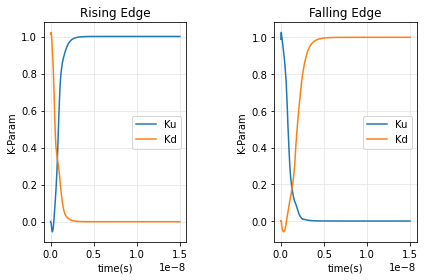

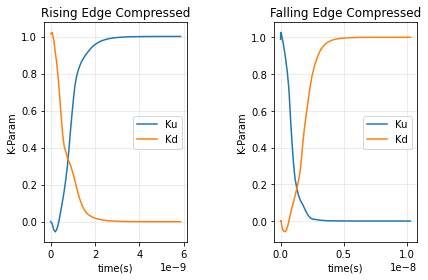

In [22]:
plot_k_params(kr, kf, 'time(s)', 'K-Param', 'Rising Edge', 'Falling Edge')
plot_k_params(kr_compressed, kf_compressed, 'time(s)', 'K-Param', 'Rising Edge Compressed', 'Falling Edge Compressed')

#### Determine Crossover point and Offsets

To provide a SPICE subcircuit model that can dynamically adjust the frequency of the osicllation stimulus, a method to determine the points at which a full period is calculated is requried.

It is most convenient to use the crossover points of the Ku and Kd wavforms to determine the timing between the positive and negative pulses within a period.

In [23]:
# Rising Edge approx. crossover time point (x_r)
index = np.argmin(np.absolute(kr_compressed[:,1] - kr_compressed[:,2]))
x_r = kr_compressed[index, 0]

# Falling Edge approx. crossover time point (x_f)
index = np.argmin(np.absolute(kf_compressed[:,1] - kf_compressed[:,2]))
x_f = kf_compressed[index, 0]

# Rising Edge Time offset
offset_r_neg = x_r - kr_compressed[0][0];  
offset_r_pos = kr_compressed[:,0][-1] - x_r;

# Falling Edge Time offset
offset_f_neg = x_f - kf_compressed[0][0];
offset_f_pos = kf_compressed[:,0][-1] - x_f;

## SPICE Subcircuit Definition

In [24]:
def convert_iv_table_to_str(voltage, current): 
    str = f'{voltage[0]}, {current[0]}'
    for i in range(1, len(voltage)): 
        str = str + f', {voltage[i]}, {current[i]}'
    return str

def create_edge_waveform_pwl(time, k_param):
    str = f'{{delay}}, {k_param[0]}'
    for i in range(1, len(time)): 
        str = str + f', {{delay+{time[i]}}}, {k_param[i]}'
    return str

def create_osc_waveform_pwl_old(t_r, k_r, t_f, k_f):
    # t_r - time array for k_r waveform
    # t_f - time array for k_f waveform
    # k_r - ku/kd array for k_r waveform
    # k_f - ku/kd array for k_f waveform
    
    str = f'0 {k_r[0]} +{{gap_neg}} {k_r[0]} +0.01p {k_r[0]}'
    #Rising Edge
    for i in range(1, len(t_r)): 
        dt = t_r[i] - t_r[i-1]
        str = str + f' +{dt} {k_r[i]}'
    
    str = str + f' +{{gap_pos}} {k_r[-1]} +{t_f[0]} {k_f[0]}'
    #Falling Edge
    for i in range(1, len(t_f)): 
        dt = t_f[i] - t_f[i-1]
        str = str + f' +{dt} {k_f[i]}'
    
    return str

def create_osc_waveform_pwl(t_r, k_r, t_f, k_f):
    # t_r - time array for k_r waveform
    # t_f - time array for k_f waveform
    # k_r - ku/kd array for k_r waveform
    # k_f - ku/kd array for k_f waveform
    
    # the +0.01p fudge is for Simetrix as it seems to have a bug in its PWLS source where it cannot start at any value other than 0 regardless of the k_r[0] value
    str = f'0 {k_r[0]} +0.01p {k_r[0]}'
    #Rising Edge
    for i in range(1, len(t_r)): 
        dt = t_r[i] - t_r[i-1]
        str = str + f' +{dt} {k_r[i]}'
    
    str = str + f' +{{gap_pos}} {k_r[-1]} +{t_f[0]} {k_f[0]}'
    #Falling Edge
    for i in range(1, len(t_f)): 
        dt = t_f[i] - t_f[i-1]
        str = str + f' +{dt} {k_f[i]}'
    
    str = str + f' +{{gap_neg}} {k_f[-1]}'
    
    return str

### Subcircuit Data Gathering

In [25]:
# Gather the data
corner = 'Typical' # 3 options - Typical, Minimum or Maximum

if corner == 'Minimum':
    CORNER_INDEX = 2
    c_pkg1 = float(c_pkg.minimum)     
    l_pkg1 = float(l_pkg.minimum)
    r_pkg1 = float(r_pkg.minimum)
    c_comp1 = float(c_comp.minimum)
    vcc = float(voltage_range.minimum)

elif corner == 'Maximum':
    CORNER_INDEX = 3
    c_pkg1 = float(c_pkg.maximum)     
    l_pkg1 = float(l_pkg.maximum)
    r_pkg1 = float(r_pkg.maximum)
    c_comp1 = float(c_comp.maximum)
    vcc = float(voltage_range.maximum)

else: # Default case is the Typical Corner
    CORNER_INDEX = 1
    c_pkg1 = float(c_pkg.typical)     
    l_pkg1 = float(l_pkg.typical)
    r_pkg1 = float(r_pkg.typical)
    c_comp1 = float(c_comp.typical)
    vcc = float(voltage_range.typical)

# Table Definitions as strings
pwr_clamp_table_str = convert_iv_table_to_str(np.flip(vcc - pwr_clamp[:,0]), np.flip(pwr_clamp[:,CORNER_INDEX]))
gnd_clamp_table_str = convert_iv_table_to_str(gnd_clamp[:,0], gnd_clamp[:,CORNER_INDEX])
pullup_table_str    = convert_iv_table_to_str(np.flip(vcc - pullup_table_adj[:,0]), np.flip(pullup_table_adj[:,CORNER_INDEX]))
pulldown_table_str  = convert_iv_table_to_str(pulldown_table_adj[:,0], pulldown_table_adj[:,CORNER_INDEX])

k_ur_str    = create_edge_waveform_pwl(kr_compressed[:,0], kr_compressed[:,1])
k_uf_str    = create_edge_waveform_pwl(kf_compressed[:,0], kf_compressed[:,1])
k_u_osc_str = create_osc_waveform_pwl(kr_compressed[:,0], kr_compressed[:,1], kf_compressed[:,0], kf_compressed[:,1])

k_dr_str    = create_edge_waveform_pwl(kr_compressed[:,0], kr_compressed[:,2])
k_df_str    = create_edge_waveform_pwl(kf_compressed[:,0], kf_compressed[:,2])
k_d_osc_str = create_osc_waveform_pwl(kr_compressed[:,0], kr_compressed[:,2], kf_compressed[:,0], kf_compressed[:,2])

### Write Subcircuit File

In [26]:
LTSPICE = ''
SIMETRIX = 'S'

simulation_tool = LTSPICE # Select between LTSPICE or SIMETRIX or None

if simulation_tool == SIMETRIX: 
    subcircuit_model_file_name = f'spice_models/{model_name}_{component_name}_{corner}_Simetrix.sub'
elif simulation_tool == LTSPICE: 
    subcircuit_model_file_name = f'spice_models/{model_name}_{component_name}_{corner}_LTSpice.sub'
else: 
    subcircuit_model_file_name = f'spice_models/{model_name}_{component_name}_{corner}.sub'
    

# Write the File
with open(subcircuit_model_file_name, 'w') as file:
    file.write(f'.SUBCKT {model_name}_{corner} OUT params: stimulus=0 edge=0 delay=10n freq=10Meg duty=0.5\n\n')
    
    file.write(f'.param C_pkg = {c_pkg1}\n')
    file.write(f'.param L_pkg = {l_pkg1}\n')
    file.write(f'.param R_pkg = {r_pkg1}\n')
    file.write(f'.param C_comp = {c_comp1}\n')
    file.write(f'.param V_supply = {vcc}\n\n')
    
    # Calculations to define the oscillation stimulus
    file.write(f'.param calc_gap_pos = {{(duty/freq) - {offset_r_pos} - {offset_f_neg}}}\n')
    file.write(f'.param calc_gap_neg = {{((1-duty)/freq) - {offset_f_pos} - {offset_r_neg}}}\n\n')
    
    file.write(f'.param gap_pos = {{if(calc_gap_pos <= 0, 0.1p, calc_gap_pos)}}\n')
    file.write(f'.param gap_neg = {{if(calc_gap_neg <= 0, 0.1p, calc_gap_neg)}}\n\n')
    
    file.write(f'R3 OUT N001 {{R_pkg}}\n')
    file.write(f'L1 Vdie N001 {{L_pkg}}\n')
    file.write(f'C1 OUT 0 {{C_pkg}}\n')
    file.write(f'C2 Vdie 0 {{C_comp}}\n')
    file.write(f'V13 VCC 0 {{V_supply}}\n\n')
    
    # Arbitrary Source definition for power and ground clamp
    file.write(f'B4 Vdie VCC I = table(v(Vdie), {pwr_clamp_table_str})\n')
    file.write(f'B3 Vdie 0 I = table(V(Vdie), {gnd_clamp_table_str})\n')
    
    # Arbitrary Source definition for pullup and pulldown devices
    file.write(f'B1 Vdie VCC I={{V(Ku)* table(v(Vdie), {pullup_table_str})}}\n')
    file.write(f'B5 Vdie 0 I={{V(Kd)*table(V(vdie), {pulldown_table_str})}}\n\n')
    
    # Adding some comments in the subcircuit for reference
    file.write(f'* Stimulus --> Oscillator=0, Edge=1\n')
    file.write(f'* Edge --> Rising=0, Falling=1\n\n')
    
    file.write(f'.model SW SW(Ron=1n Roff=1G Vt=0.5)\n\n')
    
    ## Pullup Device K-parameter Definition
    file.write(f'* Pullup Device\n')
    file.write(f'S1 Ku rising_pu Au 0 SW\n')
    file.write(f'S2 Ku falling_pu Bu 0 SW\n')
    file.write(f'S3 Ku oscillation_pu Cu 0 SW\n\n')

    file.write(f'V3 Au 0 {{if(stimulus==1, if(edge==0,1,0), 0)}}\n')
    file.write(f'V7 Cu 0 {{if(stimulus==0,1,0)}}\n')
    file.write(f'V8 Bu 0 {{if(stimulus==1, if(edge==1,1,0), 0)}}\n\n')
    
    # For the oscillation PWL sources, Simetrix and LTSpice implement this in a subtly different way. 
    # LTSpice uses a simple PWL source, whereas Simetrix uses a PWLS source
    
    # Insert Pullup transistor PWL Sources here
    file.write(f'V4 rising_pu 0 PWL({k_ur_str})\n') 
    file.write(f'V5 falling_pu 0 PWL({k_uf_str})\n') 
    if simulation_tool is not None:
        file.write(f'V6 oscillation_pu 0 PWL{simulation_tool} REPEAT FOREVER ({k_u_osc_str}) ENDREPEAT\n\n')
    else:
        file.write(f'V6 oscillation_pu 0 PWL({k_ur_str})\n\n')
    
    ## Pulldown Device K-parameter Definition
    file.write(f'* Pulldown Device\n')
    file.write(f'S4 Kd rising_pd Ad 0 SW\n')
    file.write(f'S5 Kd falling_pd Bd 0 SW\n')
    file.write(f'S6 Kd oscillation_pd Cd 0 SW\n\n')
    
    file.write(f'V1 Ad 0 {{if(stimulus==1, if(edge==0,1,0), 0)}}\n')
    file.write(f'V11 Cd 0 {{if(stimulus==0,1,0)}}\n')
    file.write(f'V12 Bd 0 {{if(stimulus==1, if(edge==1,1,0), 0)}}\n\n')
    
    # Insert Pulldown transistor PWL Sources here
    file.write(f'V2 rising_pd 0 PWL({k_dr_str})\n') 
    file.write(f'V9 falling_pd 0 PWL({k_df_str})\n')
    if simulation_tool is not None:
        file.write(f'V10 oscillation_pd 0 PWL{simulation_tool} REPEAT FOREVER ({k_d_osc_str}) ENDREPEAT\n\n')
    else:
        file.write(f'V10 oscillation_pd 0 PWL({k_dr_str})\n\n')
    
    file.write(f'.ends\n')
    

### Circuit Diagrams

Circuit diagram for the main subcircuit. The Ku and Kd voltages are determined through the stimulus selection circuit below.

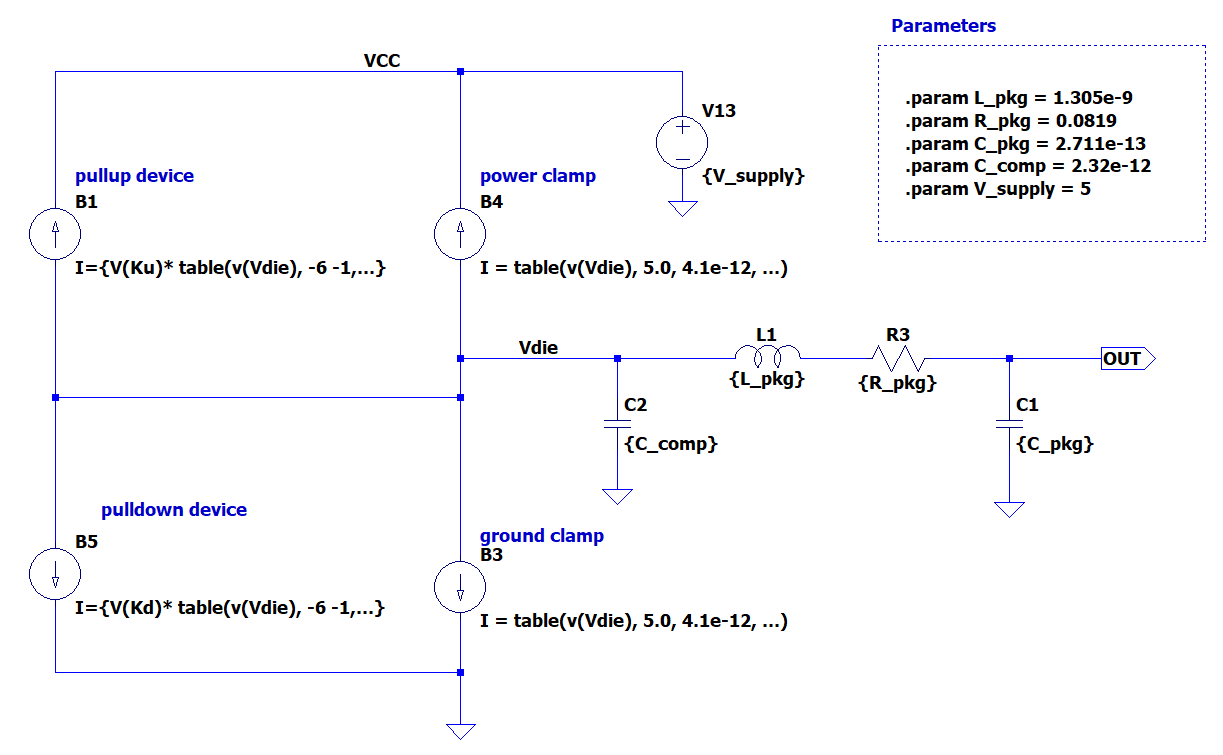

Circuit diagram for the Stimulus Selection of the pullup device is here. Pullup device is similar.

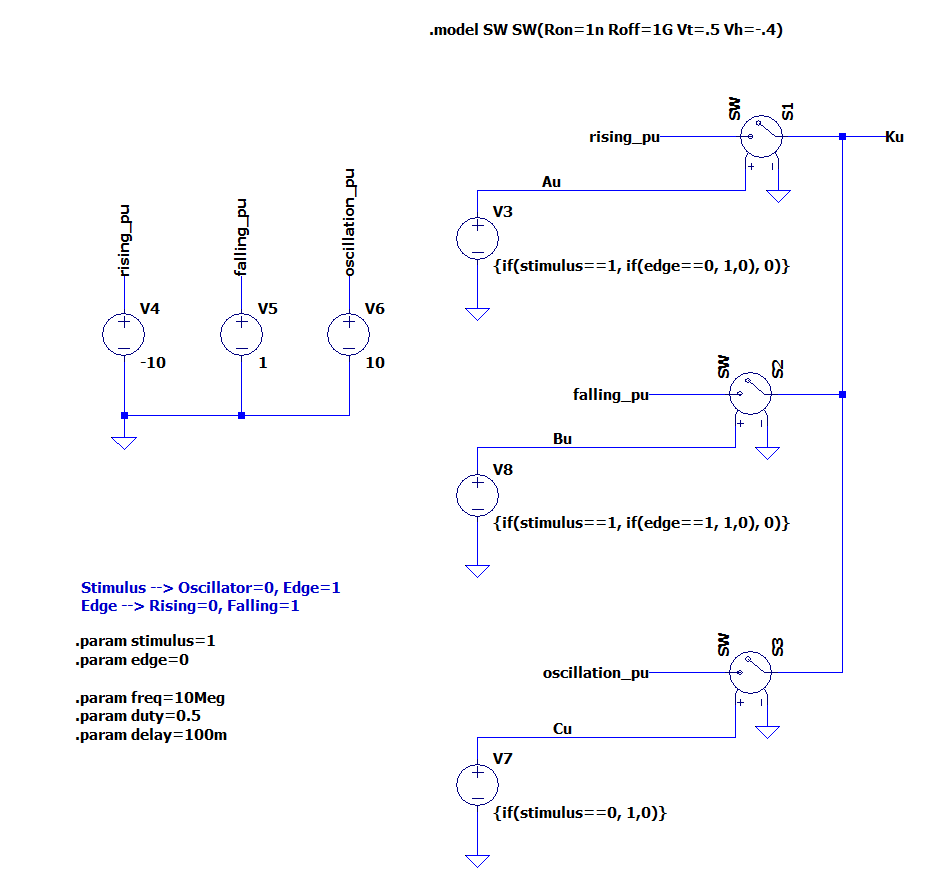